# NGSデータの概要を調べる
全リード数や分布の可視化、主成分分析などを行い、実験がうまくいっているかどうかの判断を行う。

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KernelDensity

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# color-blind safe color scheme from https://personal.sron.nl/~pault/#fig:scheme_bright
blue, cyan, green, yellow = "#4477AA", "#66CCEE", "#228833", "#CCBB44"
red, purple, grey, black = "#EE6677", "#AA3377", "#BBBBBB", "#333333"

100万リードあたりのリード数になるようCPM正規化をおこなう。この補正では遺伝子長は考慮されないが、QuantSeqでは1つの転写産物から1つのcDNAが合成されるので問題ない。

In [39]:
def normalized_cpm(df):
    return 10 ** 6 * df / df.sum()

In [56]:
df = pd.read_csv("../slamdunk/csv/allreads.csv", index_col="gene_name")

def normalized_cpm(df):
    return 10 ** 6 * df / df.sum()

df_cpm = normalized_cpm(df)    # CPM正規化
log_df = np.log2(df_cpm + 1)     # 対数変換

df.head()

,DMSO-L10a-1,DMSO-L10a-2,DMSO-L10a-3,DMSO-P0-1,DMSO-P0-2,DMSO-P0-3,DMSO-Total-1,DMSO-Total-2,DMSO-Total-3,TPG-L10a-1,TPG-L10a-2,TPG-L10a-3,TPG-P0-1,TPG-P0-2,TPG-P0-3,TPG-Total-1,TPG-Total-2,TPG-Total-3
gene_name,,,,,,,,,,,,,,,,,,
A1BG,107,33,108,142,160,85,65,84,39,75,74,75,116,82,127,94,116,75
A1CF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A2M,0,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
A2ML1,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0
A4GALT,16,3,13,0,0,4,0,6,15,6,0,1,0,19,0,5,2,0


Text(0, 0.5, 'Total reads (million)')

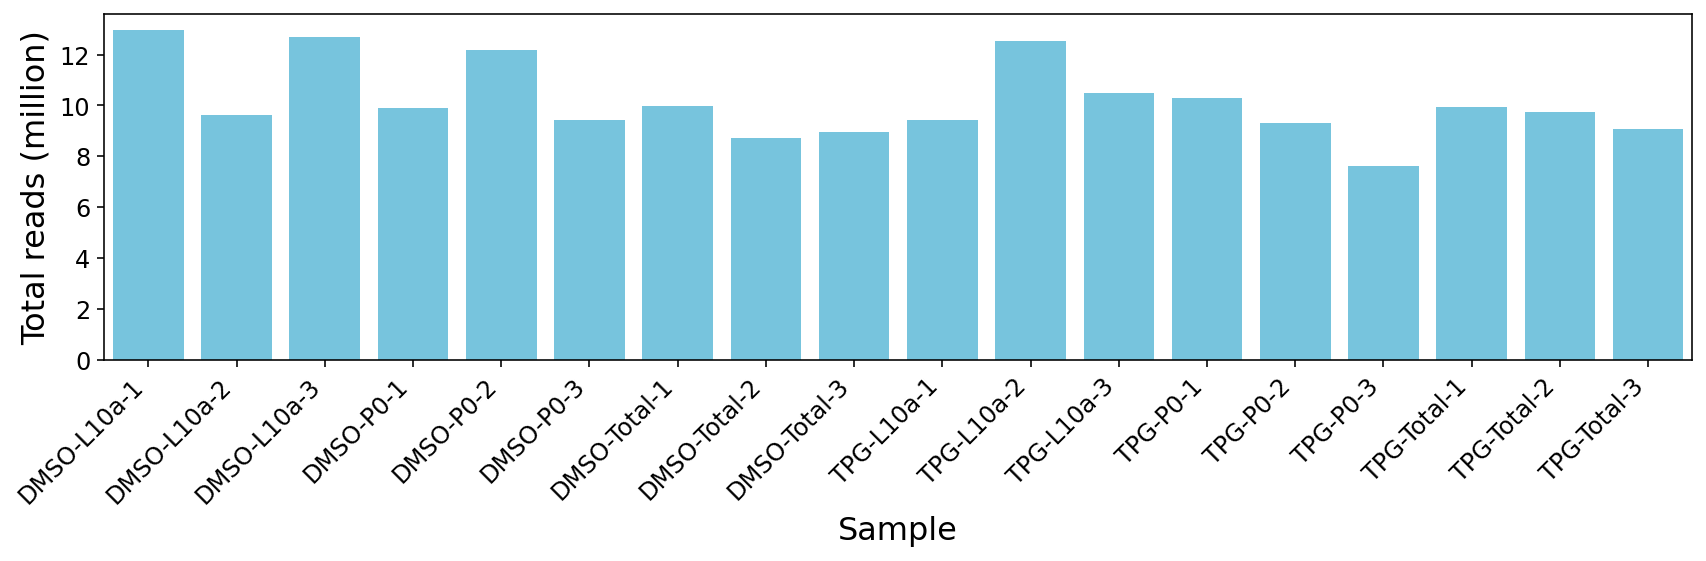

In [57]:
# subplot
fig = plt.figure(figsize=(12, 4), tight_layout=True)
ax = fig.add_subplot(1, 1, 1)

x = df.columns.values
y = np.array(df.sum() / 1000000)

sns.barplot(x=x, y=y, ax=ax, color=cyan)
fig.autofmt_xdate(rotation=45)

ax.tick_params(direction="out", labelsize=12)
ax.set_xlabel("Sample", fontsize=16)
ax.set_ylabel("Total reads (million)", fontsize=16)

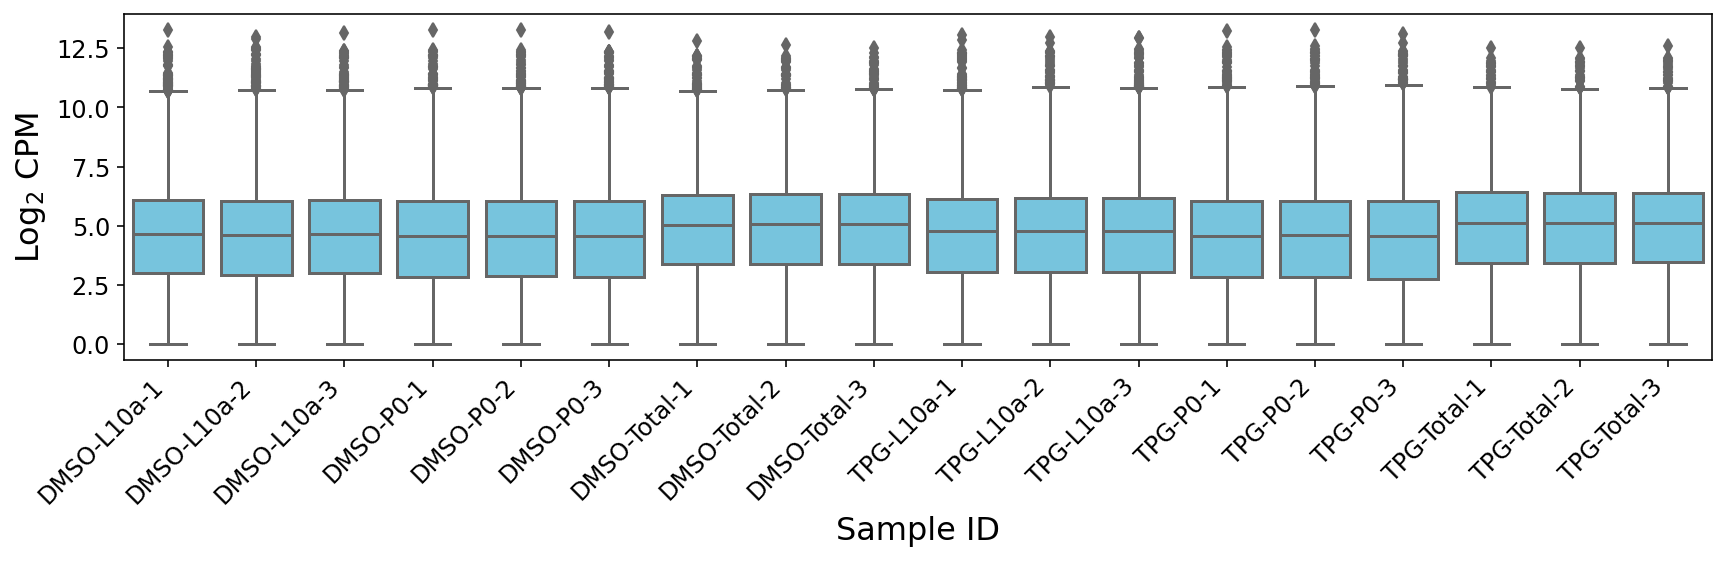

In [58]:
# リードカウントの少ない遺伝子を除外 (box plotのみ)
min_cpm = 0.5
log_df_wo_zero = log_df[log_df.sum(axis=1) >= min_cpm * len(log_df.columns)]

# subplot
fig = plt.figure(figsize=(12, 4), tight_layout=True)
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(direction="out", labelsize=12)
ax.set_xlabel("Sample ID", fontsize=16)
ax.set_ylabel("Log" + "$_{2}$" + " CPM", fontsize=16)

sns.boxplot(data=log_df_wo_zero, color="#66CCEE")
fig.autofmt_xdate(rotation=45)

Text(0, 0.5, 'Density')

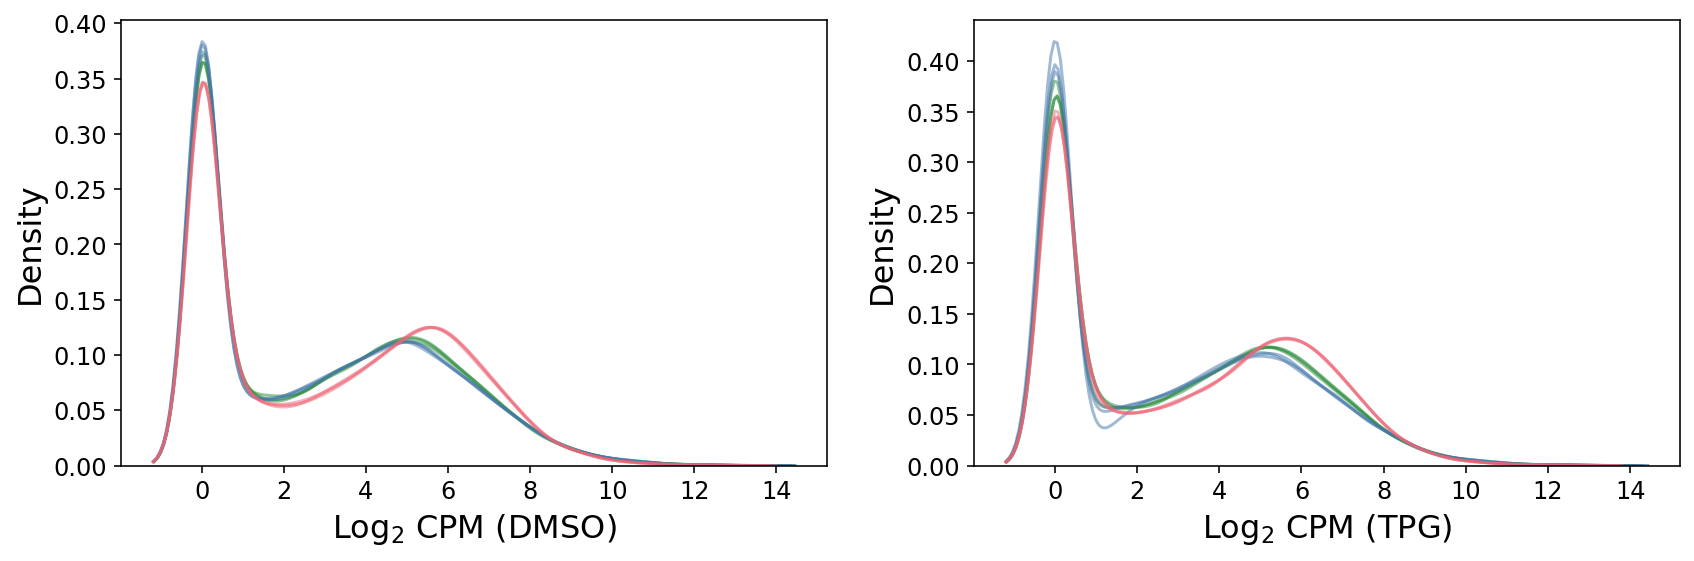

In [59]:
fig = plt.figure(figsize=(12, 4), tight_layout=True)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

sample_list = df.columns.values

for i in sample_list.tolist():
    
    if "Total" in i:
        color = "#EE6677"
    elif "L10a" in i:
        color = "#228833"
    elif "P0" in i:
        color = "#4477AA"
    
    if "DMSO" in i:
        sns.kdeplot(log_df[i], ax=ax1, color=color, alpha=0.5)
    else:
        sns.kdeplot(log_df[i], ax=ax2, color=color, alpha=0.5)

ax1.tick_params(direction="out", labelsize=12)
ax1.set_xlabel("Log" + "$_{2}$" + " CPM (DMSO)", fontsize=16)
ax1.set_ylabel("Density", fontsize=16)

ax2.tick_params(direction="out", labelsize=12)
ax2.set_xlabel("Log" + "$_{2}$" + " CPM (TPG)", fontsize=16)
ax2.set_ylabel("Density", fontsize=16)

## 主成分分析 (PCA)

In [60]:
# 解析に含める上位の値を設定
top = 1000

# 偏差の情報を付与
pca_df = log_df.copy()
pca_df["Variance"] = pca_df.var(axis=1)
pca_df = pca_df.sort_values("Variance", ascending=False)

# 偏差の値が上位の遺伝子を抽出
pca_df  = pca_df .iloc[:top, :-1]

# テーブルの転置
pca_df = pca_df.T

# 主成分分析で求める次元数
pca_number = 18

#主成分分析実行
pca = PCA(n_components=pca_number, whiten=False)
pca.fit(pca_df)

# データを主成分空間に写像
feature = pca.transform(pca_df)

ft = pd.DataFrame(feature, index=pca_df.index, columns=["PC{}".format(i + 1) for i in range(0, pca_number)])

cumulative_sum = np.cumsum(pca.explained_variance_ratio_).tolist()
pc1 = round(pca.explained_variance_ratio_.tolist()[0] * 100, 2)
pc2 = round(pca.explained_variance_ratio_.tolist()[1] * 100, 2)

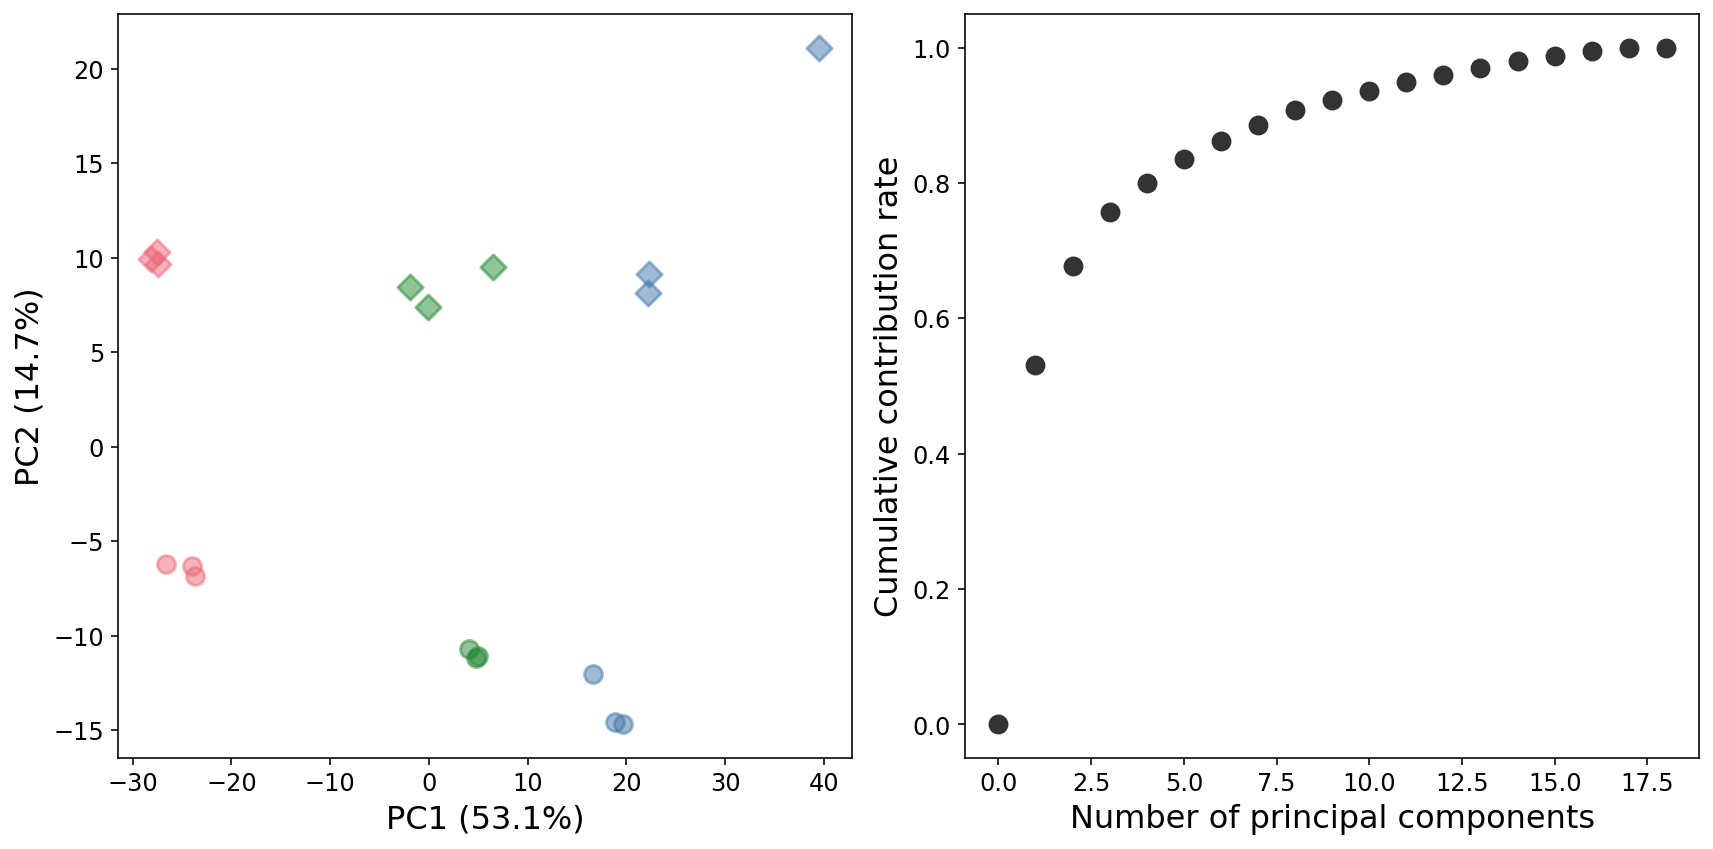

In [61]:
# subplot
fig = plt.figure(figsize=(12, 6), tight_layout=True)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

sample_list = df.columns.values
cumulative_sum = np.cumsum(pca.explained_variance_ratio_).tolist()

for i in sample_list.tolist():
    
    if "Total" in i:
        color = "#EE6677"
    elif "L10a" in i:
        color = "#228833"
    elif "P0" in i:
        color = "#4477AA"
    
    if "DMSO" in i:
        marker="o"
    else:
        marker="D" 
    
    ax1.scatter(ft[i:i]["PC1"], ft[i:i]["PC2"], color=color, marker=marker, alpha=0.5,  linewidths=1.5, s=80)

for i in range(0, len(cumulative_sum)):   
    ax2.scatter(i + 1, cumulative_sum[i], color="#333333", marker="o", s=80)

pc1 = round(pca.explained_variance_ratio_[0] * 100, 1)
pc2 = round(pca.explained_variance_ratio_[1] * 100, 1)
 
ax1.tick_params(direction="out", labelsize=12)
ax1.set_xlabel(f"PC1 ({pc1}%)", fontsize=16)
ax1.set_ylabel(f"PC2 ({pc2}%)", fontsize=16)

ax2.scatter(0, 0.001, color="#333333", marker="o", s=80)

ax2.tick_params(direction="out", labelsize=12)
ax2.set_xlabel("Number of principal components", fontsize=16)
ax2.set_ylabel("Cumulative contribution rate", fontsize=16)

fig.savefig("../figure_S2/PCA_all.pdf", dpi=300)

## 新規合成リード (T>C reads) について解析

In [62]:
df = pd.read_csv("../slamdunk/csv/tcreads.csv", index_col="gene_name")

def normalized_cpm(df):
    return 10 ** 6 * df / df.sum()

df_cpm = normalized_cpm(df)    # CPM正規化
log_df = np.log2(df_cpm + 1)     # 対数変換

df.head()

,DMSO-L10a-1,DMSO-L10a-2,DMSO-L10a-3,DMSO-P0-1,DMSO-P0-2,DMSO-P0-3,DMSO-Total-1,DMSO-Total-2,DMSO-Total-3,TPG-L10a-1,TPG-L10a-2,TPG-L10a-3,TPG-P0-1,TPG-P0-2,TPG-P0-3,TPG-Total-1,TPG-Total-2,TPG-Total-3
gene_name,,,,,,,,,,,,,,,,,,
A1BG,21,4,19,24,60,19,33,35,13,16,23,22,37,33,52,28,12,23
A1CF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A2M,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A2ML1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A4GALT,7,0,7,0,0,0,0,0,15,6,0,1,0,0,0,2,1,0


Text(0, 0.5, 'T>C reads (million)')

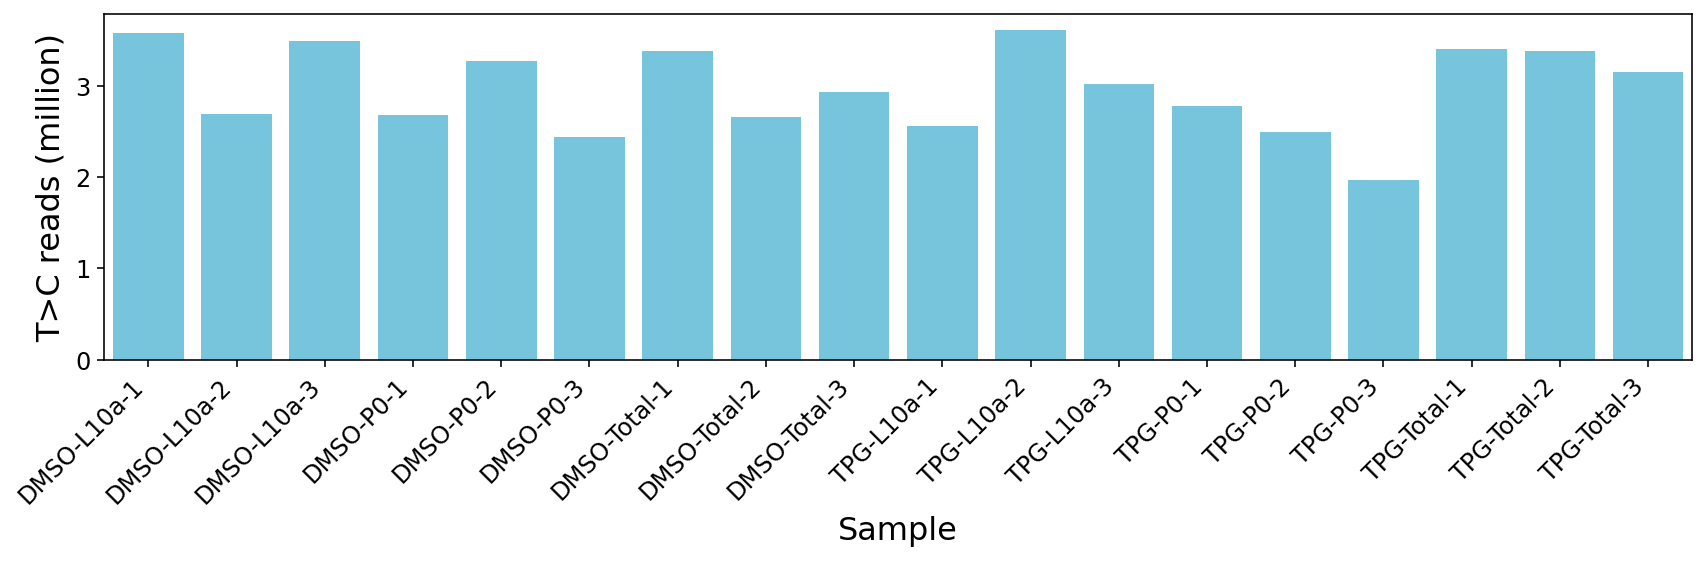

In [63]:
# subplot
fig = plt.figure(figsize=(12, 4), tight_layout=True)
ax = fig.add_subplot(1, 1, 1)

x = df.columns.values
y = np.array(df.sum() / 1000000)

sns.barplot(x=x, y=y, ax=ax, color=cyan)
fig.autofmt_xdate(rotation=45)

ax.tick_params(direction="out", labelsize=12)
ax.set_xlabel("Sample", fontsize=16)
ax.set_ylabel("T>C reads (million)", fontsize=16)

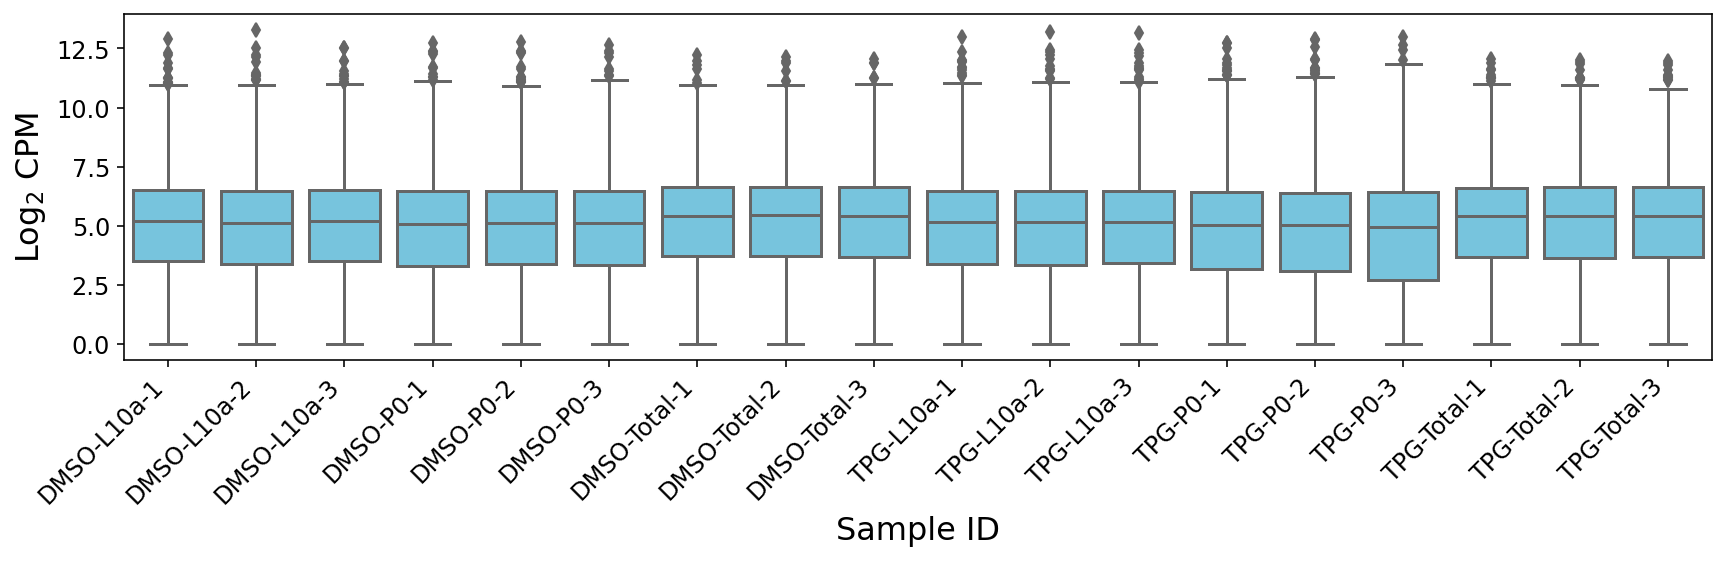

In [64]:
df_cpm = normalized_cpm(df)    # CPM正規化
log_df = np.log2(df_cpm + 1)     # 対数変換

# リードカウントの少ない遺伝子を除外 (box plotのみ)
min_cpm = 0.5
log_df_wo_zero = log_df[log_df.sum(axis=1) >= min_cpm * len(log_df.columns)]

# subplot
fig = plt.figure(figsize=(12, 4), tight_layout=True)
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(direction="out", labelsize=12)
ax.set_xlabel("Sample ID", fontsize=16)
ax.set_ylabel("Log" + "$_{2}$" + " CPM", fontsize=16)

sns.boxplot(data=log_df_wo_zero, color="#66CCEE")
fig.autofmt_xdate(rotation=45)

Text(0, 0.5, 'Density')

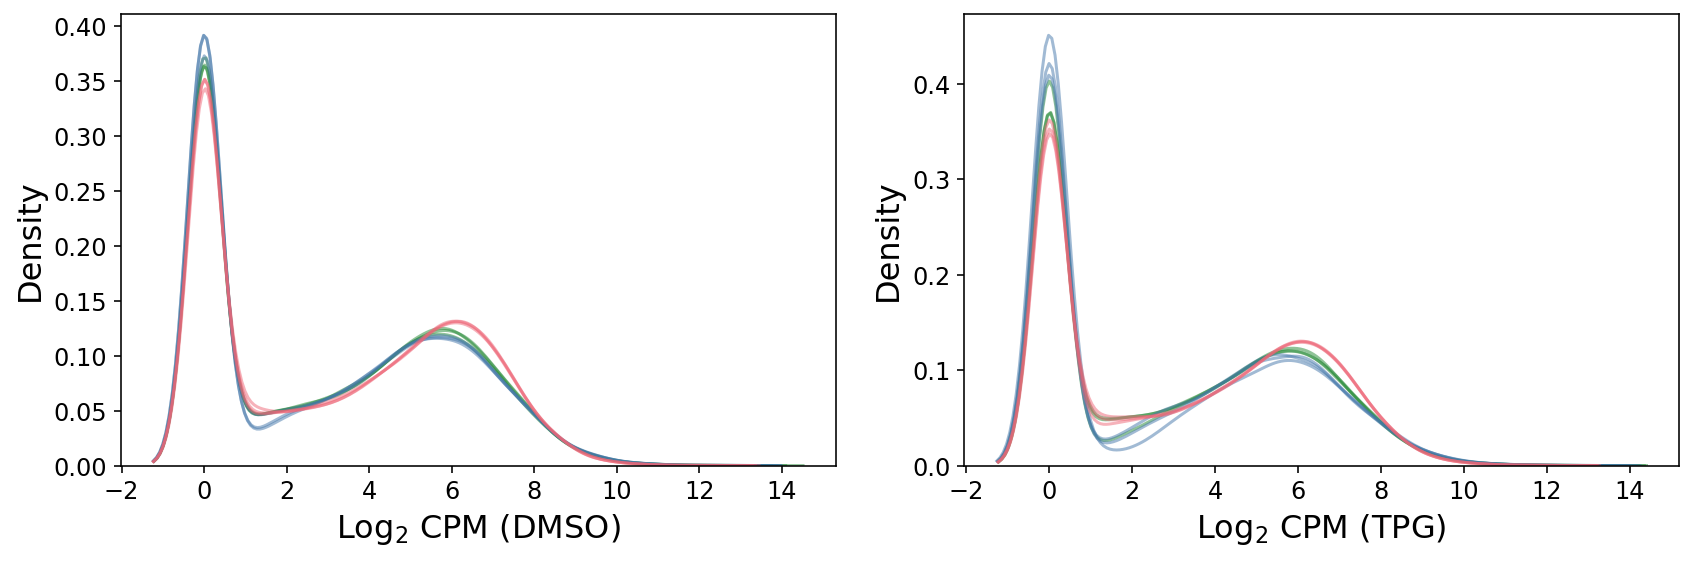

In [65]:
fig = plt.figure(figsize=(12, 4), tight_layout=True)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

sample_list = df.columns.values

for i in sample_list.tolist():
    
    if "Total" in i:
        color = "#EE6677"
    elif "L10a" in i:
        color = "#228833"
    elif "P0" in i:
        color = "#4477AA"
    
    if "DMSO" in i:
        sns.kdeplot(log_df[i], ax=ax1, color=color, alpha=0.5)
    else:
        sns.kdeplot(log_df[i], ax=ax2, color=color, alpha=0.5)

ax1.tick_params(direction="out", labelsize=12)
ax1.set_xlabel("Log" + "$_{2}$" + " CPM (DMSO)", fontsize=16)
ax1.set_ylabel("Density", fontsize=16)

ax2.tick_params(direction="out", labelsize=12)
ax2.set_xlabel("Log" + "$_{2}$" + " CPM (TPG)", fontsize=16)
ax2.set_ylabel("Density", fontsize=16)

## 主成分分析

In [66]:
# 解析に含める上位の値を設定
top = 1000

# 偏差の情報を付与
pca_df = log_df.copy()
pca_df["Variance"] = pca_df.var(axis=1)
pca_df = pca_df.sort_values("Variance", ascending=False)

# 偏差の値が上位の遺伝子を抽出
pca_df  = pca_df .iloc[:top, :-1]

# テーブルの転置
pca_df = pca_df.T

# 主成分分析で求める次元数
pca_number = 18

#主成分分析実行
pca = PCA(n_components=pca_number, whiten=False)
pca.fit(pca_df)

# データを主成分空間に写像
feature = pca.transform(pca_df)

ft = pd.DataFrame(feature, index=pca_df.index, columns=["PC{}".format(i + 1) for i in range(0, pca_number)])

cumulative_sum = np.cumsum(pca.explained_variance_ratio_).tolist()
pc1 = round(pca.explained_variance_ratio_.tolist()[0] * 100, 2)
pc2 = round(pca.explained_variance_ratio_.tolist()[1] * 100, 2)

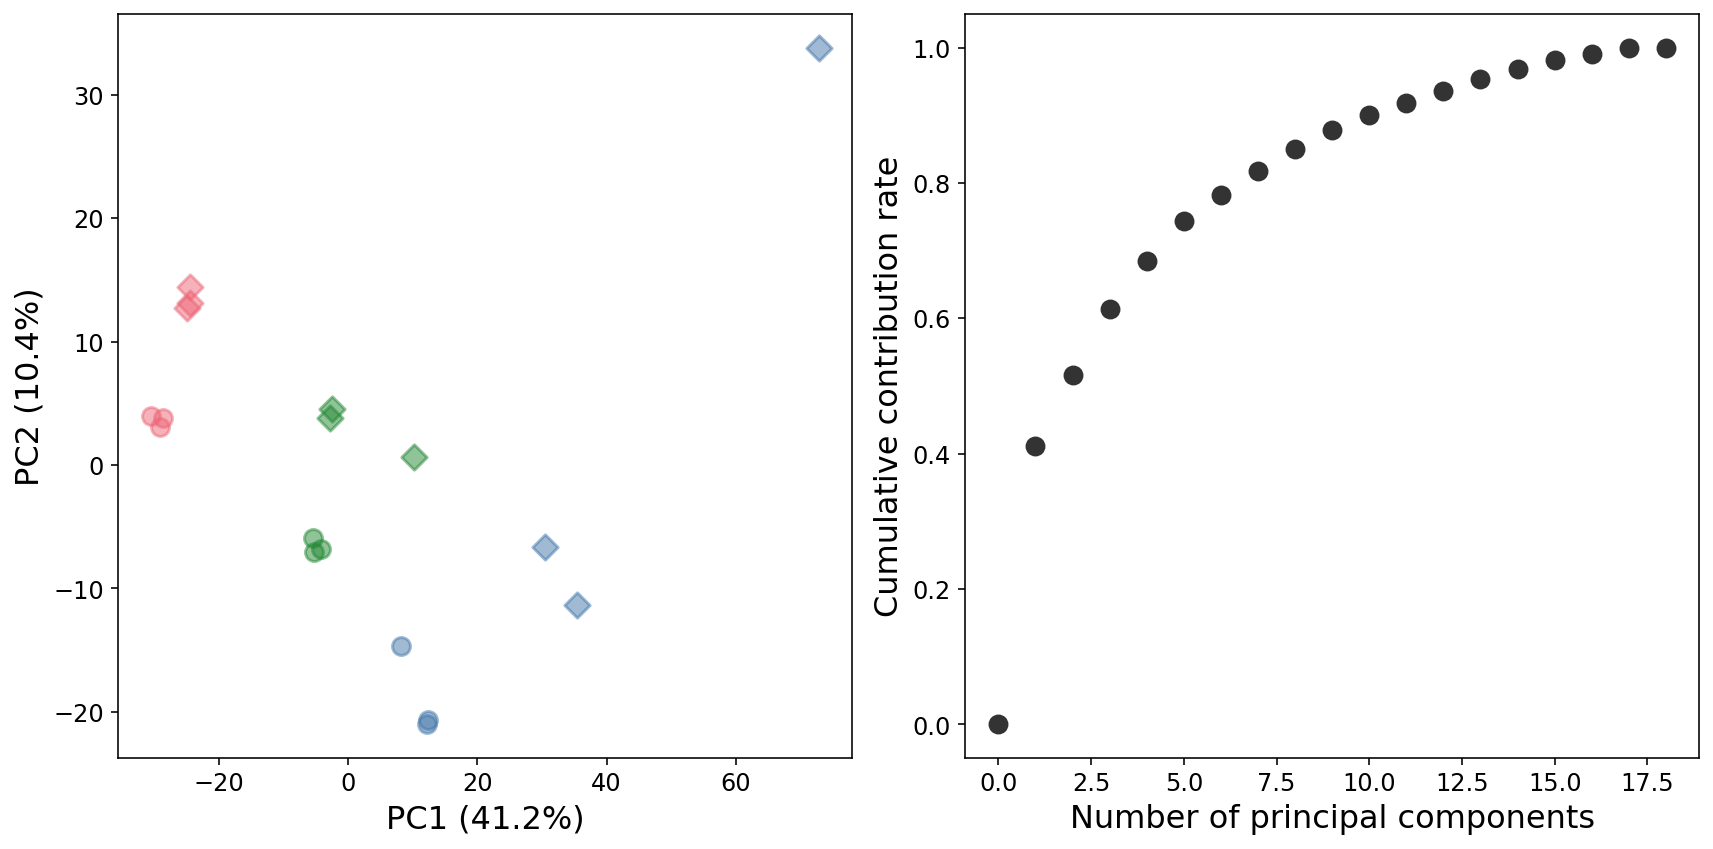

In [67]:
# subplot
fig = plt.figure(figsize=(12, 6), tight_layout=True)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

sample_list = df.columns.values
cumulative_sum = np.cumsum(pca.explained_variance_ratio_).tolist()

for i in sample_list.tolist():
    
    if "Total" in i:
        color = "#EE6677"
    elif "L10a" in i:
        color = "#228833"
    elif "P0" in i:
        color = "#4477AA"
    
    if "DMSO" in i:
        marker="o"
    else:
        marker="D" 
    
    ax1.scatter(ft[i:i]["PC1"], ft[i:i]["PC2"], color=color, marker=marker, alpha=0.5,  linewidths=1.5, s=80)

for i in range(0, len(cumulative_sum)):   
    ax2.scatter(i + 1, cumulative_sum[i], color="#333333", marker="o", s=80)

pc1 = round(pca.explained_variance_ratio_[0] * 100, 1)
pc2 = round(pca.explained_variance_ratio_[1] * 100, 1)
 
ax1.tick_params(direction="out", labelsize=12)
ax1.set_xlabel(f"PC1 ({pc1}%)", fontsize=16)
ax1.set_ylabel(f"PC2 ({pc2}%)", fontsize=16)

ax2.scatter(0, 0.001, color="#333333", marker="o", s=80)

ax2.tick_params(direction="out", labelsize=12)
ax2.set_xlabel("Number of principal components", fontsize=16)
ax2.set_ylabel("Cumulative contribution rate", fontsize=16)

fig.savefig("../figure_S2/PCA_tc.pdf", dpi=300)